In [1]:
### Requirements: PyDotPlus, Matplotlib, Scikit-Learn, Pandas, Numpy, IPython (and possibly GraphViz)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
import sklearn
import sklearn.metrics as skm
from scipy import misc
from sklearn.externals.six import StringIO  
import pydotplus
from IPython.display import Image, YouTubeVideo

def visualize_tree(tree, feature_names, class_names):
    dot_data = StringIO()  
    sklearn.tree.export_graphviz(tree, out_file=dot_data, 
                         filled=True, rounded=True,  
                         feature_names=feature_names,
                         class_names=class_names,
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return graph.create_png()

# EECS 445: Machine Learning
## Lecture 12: Bagging and Boosting
- Instructor: **Jacob Abernethy**
- Date: October 19, 2016

Lecture Exposition Credit: Valliappa Chockalingam

## Announcements

- **Midterm** in class on Monday, October 24
- Come to the section in which *you are enrolled*
- You can bring notes, no more than 3 pieces of paper (double sided)
- Bring an ID. No calculators allowed
- Topics: lectures 1-11, see Piazza post for details
- Note: **No Lecture on Wednesday October 26**

## Quick review of information gain and decision trees

### Metrics: Information Gain (Mutual Information)
#### Used by the ID3, C4.5 and C5.0 tree-generation algorithms. 
  
Assume the true binary labels $\{y_i : i =1\ldots m\}$ are distribution according to $P(y)$. But when we observe the value of a decision stump $A = T\text{ or }F$, then we obtain two new distributions, $P(y \mid a = T)$ and $P(y \mid a = F)$. We use *information gain* to measure how much the distribution on $y$ changes when we observe $a$.

\begin{align*}
\text{Information Gain } & = \text{ Entropy(Parent) - } \text{ Weighted Sum of Entropy(Children)} \\
 & = IG(P,A) = H(P) - H(P|A) \\
 & = H(P) - \sum_{A = T,F} Pr(A) H(P(\cdot | A))
\end{align*}


### A question to illustrate the Information Gain metric

Note:
 - The $[x+, y-]$ indicate the number of samples belonging to the two classes, say positive and negative. 
 - The topmost one denotes the number of positive and negative samples in the dataset before "any partitioning."

![DecisionTreeExample](images/InformationGain.png)

## Good Notes on Information Gain and DTs

[See thse notes from CMU](http://www.cs.cmu.edu/~awm/10701/slides/DTreesAndOverfitting-9-13-05.pdf)

### So, what is Information Gain?

- Intuitively, Information Gain captures: 
 - The mutual information that there is between an attribute and the class labels, or, equivalently, 
 - The reduction in entropy gained by observing an attribute.
- Another intersting note: 
 - Mutual information (i.e., Information Gain) and KL-divergence are connected: $IG(X, Y) = D_{KL}(p(x, y) \mid \mid p(x)p(y))$.

### Alternative: Misclassification Error

If we think of a node $A$ as simply "guessing" $A(x)$ for the label $y$ of $x$, then the Misclassification Error (ME) is essentially the probability $P(A(x) = y)$

$$\text{ME}(A) = \frac{\sum_{i=1}^N \mathbb{I}[ A(x_i) = y_i ] }{N}$$

- Often, we imagine that the misclassification error of a node is either the error rate of $A$ **or** the error rate of $\neg A$. We might call this $\text{ME}^*$.

$$\text{ME}^*(A) = \min(\text{ME}(A), \text{ME}(\neg A))$$


### Generalizations of Decision Trees (1)
- Decision Trees in their simplest form involve:
 - A 2-class scenario, with, 
 - Binary Features, and use a,
 - Binary Tree (every node has at most 2 children).
  
However, generalizations are possible.

### Generalizations of Decision Trees (2)
- Categorical Features 
 - Can use $n$-ary trees rather than binary search trees 
   - Fruits Tree Example: Color? asked at the root had three choices: Red, Yellow or Green (Ternary Tree)
 - Can use questions such as "$x_i$ = $l$?" or even $"2 \leq x_i \leq l$?", where $x_i \in \{1, ..., l, ..., K\}$?
   - The Mushroom Classification Tree was an example of this (Binary Tree with comparative rather than only equality checking conditions).

### Generalizations of Decision Trees (3)
- Categorical Output/Multiclass Scenario (the Fruits Example)
 - One way to handle categorical outputs is to pose a question such as "Is it a bird?" when "Yes" is expected. This keeps the outputs binary.
 - Another way is to simply use a **one-hot encoding** for the output (Ex: Bird corresponds to $[0, 0, 0, 0, 0, 1, 0]$) 
- Real-Valued Response (Output). Decision Trees are typically designed for binary problems, i.e. classification. But they can be used for regression! However, applying DTs for regression usually involves discretizing the output space either in some way.
- [More on DTs for classification and regression](http://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/)

### Decision Tree Computation Limitations

Decision Trees in general perform well with lots of data, are robust to violations of assumptions, and probably most strikingly are easy to understand and interpret. However:
 - The problem of Learning an optimal Decision Trees is NP-Complete under several definitions of optimal.
  - Standard algs are "greedy", make myopic decisions that may not be globally optimal.
 - There are concepts that are hard to learn using Decision Trees, which are also generally hard for other linear classifiers, as the Decision Tree learned is prohibitively large. These include "toy" problems such as: 
  - XOR, Parity or Multiplexer based Problems

## Decision Tree overfitting

With a decision tree it is easy to overfit your data!
    <img src="images/dt_overfit.png" width=40%>

## Decision Tree overfitting

We need to control the "complexity" of the hypothesis
    <img src="images/dt_wellfit.png" width=40%>
One straightforward way to do this: limit the depth of the tree!

### Inductive Bias

- What is the policy by which a particular decision tree algorithm generalizes from observed training examples to classify unseen instances?

- ***Definition:*** The set of assumptions that, together with the training data, deductively justify the classifications assigned by the learner to future instances.

- We can also think of this bias as an algorithm's "preference" over possibly hypotheses.

[More here](https://en.wikipedia.org/wiki/Inductive_bias)

### Inductive Bias of Decision Tree Algorithms

- When a decision tree is built, it is almost always not the only tree that will perfectly classify the training set!
- Finding the inductive bias of a decision tree algorithm is basically trying to find the type of tree that the algorithm favors in general. 
- It turns out that two of the common decision tree algorithms (ID3 and C4.5) have the same approximate inductive bias:
 - Prefers shorter trees over larger trees, and,
 - Trees that place high information gain attributes close to the root over those that do not. 

### Occam's Razor: "the simpler the better."

- If a larger tree classifies the training set just as well as the shorter hypothesis, then we would logically want to use the shorter tree as it performs the same, is smaller, and is quicker to build.
- But is it always the case that shorter, more simpler hypotheses are preferred over larger ones? 
- Occam's razor is a heuristic, that we should be biased in preferring simpler hypotheses to complex ones. But this idea is in some sense a foundational principle in Machine Learning.


### Dealing with Overfitting

- Simple Method: Grow the tree and check error iteratively, stop at a point where error rate is satisfactory or tree has reached some limit.
- **Pruning**: Construct a large decision tree. Use a method such as cross-validation and prune nodes from the leaves upwards. If removing a node does not change performance, make the change permanent. This can also be done for entire subtrees.
- Use Ensemble Methods!

### Ensemble Methods
- In supervised ML, our goal is to find a hypothesis that performs well on **unseen data**. 
- Finding a single hypothesis within the hypothesis space that gives good predictions can be hard.  
- Idea of Ensemble Methods: "Combine" multiple hypotheses to form a (hopefully) better hypothesis.
- The notion of "combine" is important, and we'll discuss this
- ***Note***: The hypothesis represented by an Ensemble Model is not necessarily contained within the hypothesis space of the constituent models!

### Bagging (**B**ootstrap **Agg**regat**ing**)

- Given a datset $\mathcal{D}$, $|\mathcal{D}| = n$.
- Create multiple ***bootstrap samples*** $\mathcal{D}^{'}_i, i \in \{1, ..., m\}$ such that $\forall i, |\mathcal{D}^{'}_i| = n^{'}$ using ***sampling with replacement.***
- Fit $m$ models using the above $m$ bootstrap samples 
 - ***Note:*** No pruning or stopping is used. Bagging helps when the models are unstable and can hurt if they are not.
- Given a new input $\mathbf{x}$, run each of the $m$ classifiers and use a **majority vote** to classify $\mathbf{x}$.

***Note:*** Bagging can also be applied for regression but instead of using majority vote, the average is used.

<img src="images/BaggingCropped.png">

### Why does Bagging make sense / What's the intuition?

- With one large Decision Tree (or more generally a single complex hypothesis), the model will likely have Low Bias and High Variance (Overfits to the "random noise" in the data).
- (Large) Decision Trees are unstable (using slightly different datasets causes a big change in the model learned).
- So, once we train multiple Decision Trees (or in general, multiple unstable ML models), with the bootstrap samples, we can get a much more stable model that performs better by say, using majority voting. 

In [2]:
%matplotlib inline

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

def bias_variance_example():
    X_train = []
    y_train = []

    for i in range(n_repeat):
        X, y = generate(n_samples=n_train, noise=noise)
        X_train.append(X)
        y_train.append(y)

    X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

    # Loop over estimators to compare
    for n, (name, estimator) in enumerate(estimators):
        # Compute predictions
        y_predict = np.zeros((n_test, n_repeat))

        for i in range(n_repeat):
            estimator.fit(X_train[i], y_train[i])
            y_predict[:, i] = estimator.predict(X_test)

        # Bias^2 + Variance + Noise decomposition of the mean squared error
        y_error = np.zeros(n_test)

        for i in range(n_repeat):
            for j in range(n_repeat):
                y_error += (y_test[:, j] - y_predict[:, i]) ** 2

        y_error /= (n_repeat * n_repeat)

        y_noise = np.var(y_test, axis=1)
        y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
        y_var = np.var(y_predict, axis=1)

        print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
              " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                          np.mean(y_error),
                                                          np.mean(y_bias),
                                                          np.mean(y_var),
                                                          np.mean(y_noise)))

        # Plot figures
        from pylab import rcParams
        rcParams['figure.figsize'] = 9, 9
        plt.subplot(2, n_estimators, n + 1)
        plt.plot(X_test, f(X_test), "b", label="$f(x)$")
        plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

        for i in range(n_repeat):
            if i == 0:
                plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
            else:
                plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

        plt.plot(X_test, np.mean(y_predict, axis=1), "c",
                 label="$\mathbb{E}_{LS} \^y(x)$")

        plt.xlim([-5, 5])
        plt.title(name)

        if n == 0:
            plt.legend(loc="upper left", prop={"size": 11})

        plt.subplot(2, n_estimators, n_estimators + n + 1)
        plt.plot(X_test, y_error, "r", label="$error(x)$")
        plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
        plt.plot(X_test, y_var, "g", label="$variance(x)$"),
        plt.plot(X_test, y_noise, "c", label="$noise(x)$")

        plt.xlim([-5, 5])
        plt.ylim([0, 0.1])

        if n == 0:
            plt.legend(loc="upper left", prop={"size": 11})
    plt.show()

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


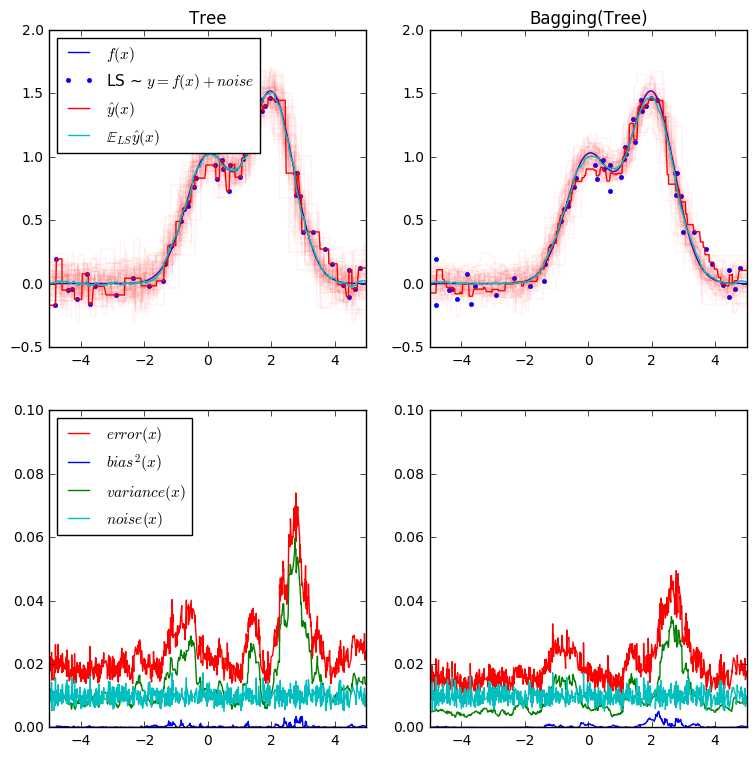

In [3]:
# Bias-Variance of Bagging with 
# Decision Tree Regressors Illustration (Adapted from ELSII, 2009)
# (Note: LS refers to a bootstrap sample)
bias_variance_example()

### Informal Bias-Variance Reasoning when using Bagging

- In general, the Bias remains about the same as we are performing model averaging and as long as the bootstrap samples represent the dataset well, the bias stays about the same.
- Variance reduces by a factor of at most the size of the bootstrap samples ($n^{'}$).
- In reality, bagging reduces variance (often by less than a factor of $n^{'}$) and tends to slightly increase bias.

### Random Forests

- Extends Bagging and in practice performs generally better.
- The only difference: When constructing the trees, best splits are found on only **a subset of the features**, not all.
 - Rule of thumb: $m = \sqrt{p}$ (rounded down) is recommended for classification problems and $\frac{p}{3}$ (rounded down) is recommended for regression where $p$ is the number of features.
- For each tree grown on a bootstrap sample, we can measure the error rate on a test set.
 - This is called the "out-of-bag" error rate.
 - This can be regarded as a generalization error and can provide a ranking of the importance of features. 

## Random Forests work **very** well in practice

Many ML competitions are won using some version of Random Forest. Hard to overstate the value of this algorithm on real-world problems.

<img src="images/random_forest.png">

### Limitations of Bagging

- Loss of interpretability: the final bagged classifier is not a tree, and so we forfeit the clear interpretative ability of a classification tree.

- Computational complexity: we are essentially multiplying the work of growing a single tree by $m$. Can be a lot of work!

## Break time!

![](images/cats.gif)

### Boosting  

- Bagging can help in reducing Variance. Are there methods that reduce both Bias and Variance? Yes! Boosting is one of them.
- General Ideas:
 - Weighted Majority Vote (unlike Bagging)
 - Elements of Ensemble built Sequentially (unlike Bagging where the models could be built parallely) 

### Boosting (2 Class Scenario)

- Assume class labels are -1 and +1.
- The final classifier then has the form: 
 - $h_T(\mathbf{x}) = \text{sgn}\left(\sum \limits_{t = 1}^T \alpha_t f_t(\mathbf{x})\right)$ where $f_1, ..., f_T$ are called base (or weak) classifiers and $\alpha_1, ..., \alpha_T > 0$ reflect the confidence of the various base classifiers.

### Base/Weak Learners

- Let $(\mathbf{x}_1, y_1), ..., (\mathbf{x}_n, y_n)$ be the training data.
- Let $\mathscr{F}$ be a fixed set of classifiers called the base class.
- A base learner for $\mathscr{F}$ is a rule that takes as input a set of weights $\mathbf{w} = (w_1, ..., w_n)$ such that $w_i \geq 0, \sum w_i = 1$, and outputs a classifier $f \in \mathscr{F}$ such that the weighted empirical risk $$e_w(f) = \sum \limits_{i = 1}^n w_i \mathbb{1}_{\{f(\mathbf{x}_i) \neq y_i\}}$$ is (approximately) minimized.

### Examples of Base (Weak) Learners

- Decision Stumps, i.e., decision trees with depth 1
- Decision Trees
- Polynomial thresholds, i.e., $$f(\vec{x}) = \pm \text{sign}((\vec{w}^\top \vec{x})^2 - b)$$ where $b \in \mathbb{R}$ and $\vec{w} \in \mathbb{R}^d$ is a radial kernel.

### AdaBoost (Adaptive Boosting)

- The first concrete algorithm to successfully realize the boosting principle.

<img src="images/adaboost.gif" width=35%>

### AdaBoost Algorithm

An *iterative* algorithm for "ensembling" base learners

- Input: $\{(\mathbf{x}_i, y_i)\}_{i = 1}^n, T, \mathscr{F}$, base learner
- Initialize: $\mathbf{w}^{1} = (\frac{1}{n}, ..., \frac{1}{n})$
- For $t = 1, ..., T$
 - $\mathbf{w}^{t} \rightarrow \boxed{\text{base learner}} \rightarrow f_t$
 - $\alpha_t = \frac{1}{2}\text{ln}\left(\frac{1 - r_t}{r_t}\right)$
     - where $r_t := e_{\mathbf{w}^t}(f_t) = \frac 1 n \sum \limits_{i = 1}^n \mathbf{w}_i \mathbf{1}_{\{f(\mathbf{x}_i) \neq y_i\}} $
 - $w_i^{t + 1} = \frac{\mathbf{w}_i^t \exp \left(- \alpha_ty_if_t(\mathbf{x}_i)\right)}{z_t}$ where $z_t$ normalizes.
- Output: $h_T(\mathbf{x}) = \text{sign}\left(\sum \limits_{t = 1}^T \alpha_t f_t(\mathbf{x})\right)$

## AdaBoost in Action

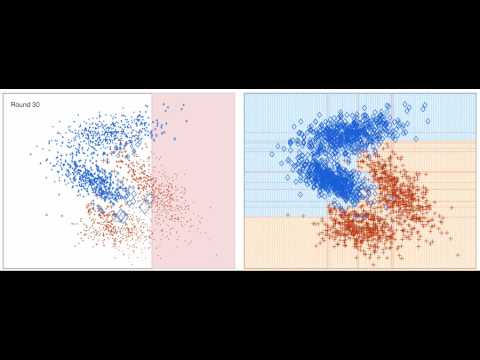

In [4]:
YouTubeVideo('k4G2VCuOMMg')

## Intuition behind Boosting

- Suppose you have a bunch of friends that give you advice
- But frequently their advice is bad advice; in fact, each of them only gives good advice 53% of the time!
- Good news: at least this is better than 50/50 :-)
- Can we use such poor advice? Yes! Just combine their opinions using a majority vote!
    - (Of course this only works when the advice they give is "independent")
- Take home message: **combining lots of weak predictions can produce a strong prediction**

## Boosting for face detection

In the context of face detection, what makes a good set of "weak learners"? Apparently a good choice are these [haar-like features](https://en.wikipedia.org/wiki/Haar-like_features). You sum up the pixel values in the white patches, minus the pixel values in the black patches.

<img src="images/slide_37.jpg">

### Strong and Weak Learnability

- Boosting's roots are in the Probably Approximately Correct "PAC" (Leslie Valiant) learning model
- Get random examples from an unknown, arbitrary distribution.
- For ***any*** distribution, given polynomially many examples (and polynomial time), a ***Strong PAC learning algorithm*** can, with high probability, find a classifier with ***arbitrarily small*** generalization error. 
- Weak PAC Learning Algorithm can do the same except the generalization error only needs to be ***slightly better than random guessing*** $\left(\frac{1}{2} - \gamma\right)$.

### Weak Learning

- Adaboost is justified by the following result.
- Let $\gamma_t = \frac{1}{2} - r_t$. Recall that $r_t = e_{\mathbf{w}^t}(f_t)$ the weighted empirical risk.
- Note that we may assume $\gamma_t \geq 0 \leftrightarrow r_t \leq \frac{1}{2}$.
- If not, just replace $f_t$ with $-f_t$ and note that for any $f$ and $\mathbf{w}$, $$e_\mathbf{w}(f) + e_\mathbf{w}(-f) = 1$$

### Theorem
(Proof in Mohri et. al, Foundations of Machine Learning, 2012)
- The training error of Adaboost satisfies $\frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{h_T(\mathbf{x}_i) \neq y_i\}} \leq \exp(-2\sum \limits_{t = 1}^T \gamma_t^2)$
- In particular, if $\forall t, \gamma_t \geq \gamma > 0$ then $\frac{1}{n} \mathbb{1}_{\{h_T(\mathbf{x}_i) \neq y_i\}} \leq \exp(-2\sum \limits_{t = 1}^T \gamma^2)$

### Weak Learning Hypothesis

- We may interpret $r_t = \frac{1}{2}$ as corresponding to a base classifier $f_t$ that randomly guesses. 
- Thus, $\gamma_t \geq \gamma > 0$ means that $f_t$ is at least slightly better than randomly guessing.
- If the base learner is guaranteed to satisfy $\gamma_t \geq \gamma > 0, \forall t$, it is said to satisfy the weak learning hypothesis.

### Interpretation of the Theorem

- The theorem says that under the weak learning hypothesis, the Adaboost training error converges to zero ***exponentially*** fast.
- Note: To avoid overfitting, the parameters $T$ should be chosen carefully. Example: Cross Validation.

### Remarks about the Adaptibility of AdaBoost 
#### 1. Can exploit $\gamma_t \gg \gamma$

- If $r_t = 0$, then $\alpha_t = \frac{1}{2}\ln\left(\frac{1 - r_t}{r_t}\right) = \lim_{r_t \rightarrow 0^{+}}\frac{1}{2}\text{ln}\left(\frac{1 - r_t}{r_t}\right) = +\infty$. 
- In other words, if $\exists$ a classifier in $\mathscr{F}$ that perfectly separates the data, AdaBoost says to just use that classifier.

####  2. $\gamma$ and $T$ do not need to be known a Priori

### Towards Generalized Boosting

- It turns out that AdaBoost can be viewed as an iterative algorithm for minimizing the empirical risk corresponding to the exponential loss.
- By generalizing the loss, we get different boosting algorithms with different properties.

### Span of a base class $\mathscr{F}$

For a fixed base class $\mathscr{F}$, define $$\text{span}(\mathscr{F}) = \{\sum \limits_{t = 1}^T \alpha_tf_t \mid T \geq 1, \alpha_t \in \mathbb{R}, f_t \in \mathscr{F}\}$$

### A Minimization Problem 

- Consider the following problem $$\min_{F \in \text{span}(\mathscr{F})} \frac{1}{n} \sum \limits_{i = 1}^n \mathbb{1}_{\{\text{sign}(F(\mathbf{x}_i)) \neq y_i\}}$$

- Now, minimizing the zero-one loss is computationally infeasible. 

### Minimizing with surrogate losses

- We can use a surrogate loss function $\phi$ instead to give the following optimization problem $$\min_{F \in \text{span}(\mathscr{F})} \frac{1}{n} \sum \limits_{i = 1}^n \phi(y_i F(\mathbf{x}_i))$$

- Examples of surrogate losses: 
 - Exponential loss: $\phi(t) = \exp(-t)$
 - Logistic Loss: $\phi(t) = log(1 + \exp(-t))$
 - Hinge Loss: $\phi(t) = \max(0, 1 - t)$
- Note: We will assume $\phi$ is differentiable and $\phi' < 0$ everywhere.

### Functional Gradient Descent
To solve the optimization problem, we can apply gradient descent on a space consisting of functions. 

### An FGD Iteration (1)

- Consider the $t^{\text{th}}$ iteration of FGD. The current iterate is $F_{t - 1} = \sum \limits_{s = 1}^{t - 1} \alpha_s f_s$.
- The next iterate will have the form $F_{t - 1} + \alpha_tf_t$

### An FGD Iteration (2)

- Now, we can view $\alpha_1, f_1, ..., \alpha_{t - 1}, f_{t - 1}$ as fixed.
- Define $B_t(\alpha, f) = \frac{1}{n}\sum \limits_{i = 1}^n \phi(y_iF_{t - 1}(\mathbf{x}_i) + y_i\alpha f(\mathbf{x}_i))$
- $f_t$ can then be chosen as the function $f \in \mathscr{F}$ for which the directional derivative of $B_t$ in the direction $f$ is minimized.
- $\alpha_t$ can be chosen as a stepsize $\alpha > 0$ in the direction $f_t$ for which $B_t(\alpha, f_t)$ is minimized.

### Mathematical Details for the choice of $f_t$ (1)

- $\left.\frac{\partial B(\alpha, f)}{\partial \alpha}\right\vert_{\alpha = 0} = \frac{1}{n}\sum \limits_{i = 1}^n y_i f(\mathbf{x}_i)\phi'(y_i F_{t - 1}(\mathbf{x}_i))$

- Minimizing the above with respect to $f$ is equivalent to minimizing $-\sum \limits_{i = 1}^n y_i f(\mathbf{x}_i)\frac{\phi'(y_iF_{t - 1}(\mathbf{x}_i))}{\sum \limits_{j = 1}^n \phi'(y_j F_{t - 1}(x_j)}$ (Note, a minus sign is used as $\phi' < 0$)

### Mathematical Details for the choice of $f_t$ (2)

- Setting $w_i^t = \frac{\phi'(y_iF_{t - 1}(\mathbf{x}_i))}{\sum \limits_{j = 1}^n \phi'(y_j F_{t - 1}(x_j)}$, the minimization problem reduces to $\sum \limits_{i = 1}^n w_i^t\mathbb{1}_{\{f(\mathbf{x}_i) \neq y_i)\}} - \sum \limits_{i = 1}^n w_i^t\mathbb{1}_{\{f(\mathbf{x}_i) = y_i\}}$

- Finally, we then get the minimization as $2\left(\sum \limits_{i = 1}^n w_i^t \mathbb{1}_{\{f(\mathbf{x}_i) = y_i\}}\right) - 1$

- Thus, to solve the first step (choose $f_t$) we just apply the base learner.

### Mathematical Details for the choice of $\alpha_t$

$$\begin{align}
\alpha_t &= \underset{\alpha}{\arg\min} \hspace{0.2cm} B_t(\alpha, f_t)\\ 
         &= \underset{\alpha}{\arg\min} \frac{1}{n}\sum \limits_{i = 1}^n \phi(y_iF_{t - 1}(\mathbf{x}_i) + y_i\alpha f_t(\mathbf{x}_i))
   \end{align}$$
   
   
The above is just a scalar minimization problem that can be solved numerically, e.g., via Newton's method, if no closed form solution is available.

### The Generalized Boosting Algorithm

- Input: $\{(\mathbf{x}_i, y_i)\}_{i = 1}^n, T, \mathscr{F}$, base learner, surrogate loss $\phi$ (differentiable, $\phi^{'} < 0$ everywhere)
- Initialize: $\mathbf{w}^{1} = (\frac{1}{n}, ..., \frac{1}{n}), F_0 = 0$
- For $t = 1, ..., T$
 - $\mathbf{w}^{t} \rightarrow \boxed{\text{base learner}} \rightarrow f_t$
 - $\alpha_t = \underset{\alpha}{\arg\min} \frac{1}{n}\sum \limits_{i = 1}^n \phi(y_iF_{t - 1}(\mathbf{x}_i) + y_i\alpha f_t(\mathbf{x}_i)$
 - $F_t = F_{t - 1} + \alpha_t f_t$
 - $w_i^{t + 1} = \frac{\phi^{'}(y_iF_t(\mathbf{x}_i))}{\sum \limits_{i = 1}^n \phi^{'}(y_iF_y(\mathbf{x}_j))}$
- End
- Output: $h_T(\mathbf{x}) = \text{sign}\left(F_T(\mathbf{x}\right)$